<a href="https://colab.research.google.com/github/vanyanenkov/DL/blob/main/2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import os
import time
from collections import defaultdict
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
import timm
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

In [ ]:
DATA_DIR = '/content/datasets'
BATCH_SIZE = 128
IMG_SIZE = 128
MODEL_NAME = 'efficientnet_b0'
NUM_EPOCHS = 25
LR_HEAD = 1e-3
LR_BACKBONE = 1e-5
WEIGHT_DECAY = 1e-4
NUM_WORKERS = 2
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
HEAD_EPOCHS = 5
VAL_EVERY = 1
VAL_SUBSET = None
USE_MIXUP = True
MIXUP_ALPHA = 0.8
SAVE_PATH = 'best_model.pth'
SEED = 50

print('Device:', DEVICE)

Device: cuda


In [ ]:
def set_seed(seed=50):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(SEED)
torch.backends.cudnn.benchmark = True

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(int(IMG_SIZE * 1.14)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_ds = datasets.CIFAR10(root=DATA_DIR, train=True, download=True, transform=train_transform)
val_ds = datasets.CIFAR10(root=DATA_DIR, train=False, download=True, transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=True, persistent_workers=True)

num_classes = 10
print('Num classes:', num_classes)
print('Train samples:', len(train_ds), 'Val samples:', len(val_ds))

100%|██████████| 170M/170M [00:03<00:00, 48.7MB/s]


Num classes: 10
Train samples: 50000 Val samples: 10000


In [ ]:
model = timm.create_model(MODEL_NAME, pretrained=True)
model.reset_classifier(num_classes=num_classes)
model.to(DEVICE)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

EfficientNet(
  (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNormAct2d(
          32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (aa): Identity()
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2

In [ ]:
for p in model.parameters():
    p.requires_grad = False

for name, p in model.named_parameters():
    if 'classifier' in name or 'head' in name or 'fc' in name:
        p.requires_grad = True

In [ ]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.0)
trainable_params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.AdamW(trainable_params, lr=LR_HEAD, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)

scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == 'cuda'))

/tmp/ipython-input-3209936643.py:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == 'cuda'))


In [ ]:
def mixup_data(x, y, alpha=0.5):
    if alpha <= 0:
        return x, y, None, None, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [ ]:
def train_one_epoch(epoch, use_mixup=False):
    model.train()
    losses = []
    preds_all = []
    targets_all = []
    loop = tqdm(train_loader, desc=f'Train {epoch}')
    for imgs, targets in loop:
        imgs = imgs.to(DEVICE)
        targets = targets.to(DEVICE)
        optimizer.zero_grad()

        if use_mixup:
            imgs_m, targets_a, targets_b, lam = mixup_data(imgs, targets, alpha=MIXUP_ALPHA)
            inputs = imgs_m
            mix = True
        else:
            inputs = imgs
            mix = False

        with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
            logits = model(inputs)
            if mix:
                loss = lam * criterion(logits, targets_a) + (1 - lam) * criterion(logits, targets_b)
            else:
                loss = criterion(logits, targets)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()

        losses.append(loss.item())
        preds_all.extend(logits.argmax(dim=1).cpu().numpy())
        targets_all.extend(targets.cpu().numpy())
        loop.set_postfix({'loss': np.mean(losses)})

    acc = accuracy_score(targets_all, preds_all)
    p, r, f1, _ = precision_recall_fscore_support(targets_all, preds_all, average='weighted')
    return np.mean(losses), acc, p, r, f1

In [ ]:
def validate(full=True, max_samples=None, epoch=None, show_batch_prints=True):
    model.eval()
    losses = []
    preds_all = []
    targets_all = []
    probs_all = []
    seen = 0
    with torch.no_grad():
        desc = f'Val   {epoch}' if epoch is not None else 'Val'
        loop = tqdm(val_loader, desc=desc, mininterval=0.1)
        for batch_idx, (imgs, targets) in enumerate(loop):
            if show_batch_prints and batch_idx % 10 == 0:
                print(f"Val batch {batch_idx}/{len(val_loader)}")

            imgs = imgs.to(DEVICE)
            targets = targets.to(DEVICE)
            with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
                logits = model(imgs)
                loss = criterion(logits, targets)
                probs = torch.softmax(logits, dim=1)
            losses.append(loss.item())
            preds_all.extend(logits.argmax(dim=1).cpu().numpy())
            targets_all.extend(targets.cpu().numpy())
            probs_all.extend(probs.cpu().numpy())
            loop.set_postfix({'loss': np.mean(losses)})
            if max_samples is not None:
                seen += imgs.size(0)
                if seen >= max_samples:
                    break

    acc = accuracy_score(targets_all, preds_all)
    p, r, f1, _ = precision_recall_fscore_support(targets_all, preds_all, average='weighted')
    try:
        y_true_onehot = np.zeros((len(targets_all), num_classes))
        for i, t in enumerate(targets_all):
            y_true_onehot[i, t] = 1
        roc_auc = roc_auc_score(y_true_onehot, np.array(probs_all), multi_class='ovr')
    except Exception:
        roc_auc = None

    return np.mean(losses), acc, p, r, f1, roc_auc, preds_all, targets_all

In [ ]:
best_val_f1 = 0.0
history = defaultdict(list)
start_time = time.time()

for epoch in range(1, NUM_EPOCHS + 1):
    # MixUp по желанию
    use_mix = USE_MIXUP
    train_loss, train_acc, train_p, train_r, train_f1 = train_one_epoch(epoch, use_mixup=use_mix)

    do_val = (epoch % VAL_EVERY == 0)
    if do_val:
        if VAL_SUBSET is not None:
            val_loss, val_acc, val_p, val_r, val_f1, val_rocauc, val_preds, val_targets = validate(full=False, max_samples=VAL_SUBSET, epoch=epoch, show_batch_prints=True)
        else:
            val_loss, val_acc, val_p, val_r, val_f1, val_rocauc, val_preds, val_targets = validate(epoch=epoch, show_batch_prints=True)
    else:
        val_loss = val_acc = val_p = val_r = val_f1 = val_rocauc = None

    if epoch == HEAD_EPOCHS:
        for name, p in model.named_parameters():
            p.requires_grad = True
        backbone_params = []
        head_params = []
        for name, p in model.named_parameters():
            if 'classifier' in name or 'head' in name or 'fc' in name:
                head_params.append(p)
            else:
                backbone_params.append(p)
        optimizer = optim.AdamW([
            {'params': head_params, 'lr': LR_HEAD},
            {'params': backbone_params, 'lr': LR_BACKBONE}
        ], weight_decay=WEIGHT_DECAY)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, NUM_EPOCHS - epoch))


    try:
        scheduler.step()
    except Exception:
        pass

    history['train_loss'].append(train_loss)
    if val_loss is not None:
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)
        history['train_f1'].append(train_f1)
        history['val_f1'].append(val_f1)

    print(f"Epoch {epoch}: train_loss={train_loss:.4f} train_acc={train_acc:.4f} train_f1={train_f1:.4f}")
    if val_loss is not None:
        print(f"           val_loss={val_loss:.4f} val_acc={val_acc:.4f} val_f1={val_f1:.4f} roc_auc={val_rocauc}")

    if val_f1 is not None and val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict(),
                    'epoch': epoch, 'num_classes': num_classes}, SAVE_PATH)
        print('Saved', SAVE_PATH)

print('Training finished in {:.1f} minutes'.format((time.time() - start_time) / 60))

Train 1:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   1:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   1:   4%|▍         | 3/79 [00:00<00:10,  6.97it/s, loss=0.964]

Val batch 0/79


Val   1:  14%|█▍        | 11/79 [00:01<00:07,  8.98it/s, loss=0.988]

Val batch 10/79


Val   1:  27%|██▋       | 21/79 [00:02<00:06,  9.17it/s, loss=1.01]

Val batch 20/79


Val   1:  39%|███▉      | 31/79 [00:03<00:05,  9.39it/s, loss=1]   

Val batch 30/79


Val   1:  52%|█████▏    | 41/79 [00:04<00:05,  6.85it/s, loss=1.01]

Val batch 40/79


Val   1:  65%|██████▍   | 51/79 [00:06<00:04,  5.67it/s, loss=1]

Val batch 50/79


Val   1:  77%|███████▋  | 61/79 [00:07<00:02,  8.22it/s, loss=0.999]

Val batch 60/79


Val   1:  90%|████████▉ | 71/79 [00:08<00:00,  9.20it/s, loss=1]

Val batch 70/79


Val   1: 100%|██████████| 79/79 [00:12<00:00,  6.25it/s, loss=1]


Epoch 1: train_loss=1.5821 train_acc=0.3672 train_f1=0.3664
           val_loss=1.0022 val_acc=0.7009 val_f1=0.6962 roc_auc=0.9590545277777777
Saved best_model.pth


Train 2:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   2:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   2:   1%|▏         | 1/79 [00:00<00:19,  4.03it/s, loss=0.97]

Val batch 0/79


Val   2:  14%|█▍        | 11/79 [00:01<00:07,  9.21it/s, loss=0.915]

Val batch 10/79


Val   2:  27%|██▋       | 21/79 [00:02<00:08,  7.18it/s, loss=0.93] 

Val batch 20/79


Val   2:  41%|████      | 32/79 [00:04<00:06,  6.80it/s, loss=0.93]

Val batch 30/79


Val   2:  53%|█████▎    | 42/79 [00:05<00:04,  8.19it/s, loss=0.931]

Val batch 40/79


Val   2:  66%|██████▌   | 52/79 [00:06<00:02, 10.07it/s, loss=0.931]

Val batch 50/79


Val   2:  78%|███████▊  | 62/79 [00:07<00:01,  9.37it/s, loss=0.927]

Val batch 60/79


Val   2:  90%|████████▉ | 71/79 [00:08<00:00,  9.45it/s, loss=0.932]

Val batch 70/79


Val   2: 100%|██████████| 79/79 [00:09<00:00,  8.49it/s, loss=0.932]


Epoch 2: train_loss=1.4923 train_acc=0.3853 train_f1=0.3848
           val_loss=0.9322 val_acc=0.7307 val_f1=0.7234 roc_auc=0.965429811111111
Saved best_model.pth


Train 3:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   3:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   3:   1%|▏         | 1/79 [00:00<00:23,  3.33it/s, loss=0.884]

Val batch 0/79


Val   3:  14%|█▍        | 11/79 [00:01<00:06, 10.04it/s, loss=0.842]

Val batch 10/79


Val   3:  27%|██▋       | 21/79 [00:02<00:05,  9.91it/s, loss=0.857]

Val batch 20/79


Val   3:  39%|███▉      | 31/79 [00:03<00:05,  8.95it/s, loss=0.854]

Val batch 30/79


Val   3:  52%|█████▏    | 41/79 [00:04<00:05,  6.36it/s, loss=0.854]

Val batch 40/79


Val   3:  65%|██████▍   | 51/79 [00:06<00:04,  5.71it/s, loss=0.851]

Val batch 50/79


Val   3:  77%|███████▋  | 61/79 [00:07<00:02,  8.42it/s, loss=0.847]

Val batch 60/79


Val   3:  90%|████████▉ | 71/79 [00:08<00:00,  9.49it/s, loss=0.851]

Val batch 70/79


Val   3: 100%|██████████| 79/79 [00:09<00:00,  8.47it/s, loss=0.852]


Epoch 3: train_loss=1.4274 train_acc=0.4221 train_f1=0.4216
           val_loss=0.8521 val_acc=0.7497 val_f1=0.7441 roc_auc=0.9695253888888888
Saved best_model.pth


Train 4:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   4:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   4:   1%|▏         | 1/79 [00:00<00:18,  4.23it/s, loss=0.923]

Val batch 0/79


Val   4:  14%|█▍        | 11/79 [00:01<00:07,  9.12it/s, loss=0.851]

Val batch 10/79


Val   4:  27%|██▋       | 21/79 [00:02<00:06,  9.44it/s, loss=0.865]

Val batch 20/79


Val   4:  39%|███▉      | 31/79 [00:03<00:04,  9.84it/s, loss=0.864]

Val batch 30/79


Val   4:  52%|█████▏    | 41/79 [00:04<00:03, 10.12it/s, loss=0.862]

Val batch 40/79


Val   4:  65%|██████▍   | 51/79 [00:05<00:02,  9.68it/s, loss=0.857]

Val batch 50/79


Val   4:  77%|███████▋  | 61/79 [00:07<00:02,  6.33it/s, loss=0.852]

Val batch 60/79


Val   4:  90%|████████▉ | 71/79 [00:08<00:01,  6.59it/s, loss=0.854]

Val batch 70/79


Val   4: 100%|██████████| 79/79 [00:09<00:00,  8.48it/s, loss=0.854]


Epoch 4: train_loss=1.4145 train_acc=0.4314 train_f1=0.4308
           val_loss=0.8542 val_acc=0.7557 val_f1=0.7541 roc_auc=0.9706775999999999
Saved best_model.pth


Train 5:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   5:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   5:   1%|▏         | 1/79 [00:00<00:17,  4.36it/s, loss=0.888]

Val batch 0/79


Val   5:  14%|█▍        | 11/79 [00:01<00:07,  8.89it/s, loss=0.841]

Val batch 10/79


Val   5:  27%|██▋       | 21/79 [00:02<00:05, 10.29it/s, loss=0.862]

Val batch 20/79


Val   5:  39%|███▉      | 31/79 [00:03<00:05,  9.24it/s, loss=0.861]

Val batch 30/79


Val   5:  51%|█████     | 40/79 [00:04<00:04,  8.91it/s, loss=0.862]

Val batch 40/79


Val   5:  66%|██████▌   | 52/79 [00:05<00:02, 10.08it/s, loss=0.857]

Val batch 50/79


Val   5:  76%|███████▌  | 60/79 [00:06<00:01,  9.96it/s, loss=0.854]

Val batch 60/79


Val   5:  89%|████████▊ | 70/79 [00:08<00:01,  5.93it/s, loss=0.854]

Val batch 70/79


Val   5: 100%|██████████| 79/79 [00:09<00:00,  8.64it/s, loss=0.851]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Epoch 5: train_loss=1.4108 train_acc=0.3851 train_f1=0.3846
           val_loss=0.8510 val_acc=0.7475 val_f1=0.7428 roc_auc=0.9699607666666665


Train 6:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   6:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   6:   1%|▏         | 1/79 [00:00<00:19,  3.91it/s, loss=0.822]

Val batch 0/79


Val   6:  14%|█▍        | 11/79 [00:01<00:07,  8.60it/s, loss=0.798]

Val batch 10/79


Val   6:  27%|██▋       | 21/79 [00:02<00:07,  7.53it/s, loss=0.813]

Val batch 20/79


Val   6:  39%|███▉      | 31/79 [00:04<00:07,  6.14it/s, loss=0.811]

Val batch 30/79


Val   6:  52%|█████▏    | 41/79 [00:05<00:04,  8.21it/s, loss=0.81] 

Val batch 40/79


Val   6:  65%|██████▍   | 51/79 [00:06<00:02,  9.38it/s, loss=0.805]

Val batch 50/79


Val   6:  78%|███████▊  | 62/79 [00:07<00:01,  9.10it/s, loss=0.8]

Val batch 60/79


Val   6:  91%|█████████ | 72/79 [00:08<00:00,  9.09it/s, loss=0.803]

Val batch 70/79


Val   6: 100%|██████████| 79/79 [00:09<00:00,  8.26it/s, loss=0.803]


Epoch 6: train_loss=1.3386 train_acc=0.4234 train_f1=0.4229
           val_loss=0.8034 val_acc=0.7842 val_f1=0.7822 roc_auc=0.9763551999999999
Saved best_model.pth


Train 7:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   7:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   7:   1%|▏         | 1/79 [00:00<00:17,  4.46it/s, loss=0.726]

Val batch 0/79


Val   7:  14%|█▍        | 11/79 [00:01<00:07,  9.58it/s, loss=0.682]

Val batch 10/79


Val   7:  27%|██▋       | 21/79 [00:02<00:06,  9.43it/s, loss=0.696]

Val batch 20/79


Val   7:  39%|███▉      | 31/79 [00:03<00:04, 10.03it/s, loss=0.698]

Val batch 30/79


Val   7:  51%|█████     | 40/79 [00:04<00:04,  8.26it/s, loss=0.694]

Val batch 40/79


Val   7:  63%|██████▎   | 50/79 [00:05<00:03,  7.36it/s, loss=0.691]

Val batch 50/79


Val   7:  76%|███████▌  | 60/79 [00:07<00:02,  6.73it/s, loss=0.688]

Val batch 60/79


Val   7:  91%|█████████ | 72/79 [00:08<00:00,  8.48it/s, loss=0.692]

Val batch 70/79


Val   7: 100%|██████████| 79/79 [00:09<00:00,  8.51it/s, loss=0.69]


Epoch 7: train_loss=1.2931 train_acc=0.4522 train_f1=0.4520
           val_loss=0.6903 val_acc=0.8274 val_f1=0.8257 roc_auc=0.9834874333333333
Saved best_model.pth


Train 8:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   8:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   8:   1%|▏         | 1/79 [00:00<00:19,  3.95it/s, loss=0.638]

Val batch 0/79


Val   8:  15%|█▌        | 12/79 [00:01<00:06,  9.79it/s, loss=0.598]

Val batch 10/79


Val   8:  27%|██▋       | 21/79 [00:02<00:06,  9.63it/s, loss=0.609]

Val batch 20/79


Val   8:  39%|███▉      | 31/79 [00:03<00:04, 10.24it/s, loss=0.614]

Val batch 30/79


Val   8:  53%|█████▎    | 42/79 [00:04<00:03,  9.79it/s, loss=0.612]

Val batch 40/79


Val   8:  63%|██████▎   | 50/79 [00:05<00:03,  9.33it/s, loss=0.608]

Val batch 50/79


Val   8:  78%|███████▊  | 62/79 [00:06<00:01,  9.47it/s, loss=0.604]

Val batch 60/79


Val   8:  89%|████████▊ | 70/79 [00:07<00:00,  9.22it/s, loss=0.607]

Val batch 70/79


Val   8: 100%|██████████| 79/79 [00:08<00:00,  9.51it/s, loss=0.604]


Epoch 8: train_loss=1.2298 train_acc=0.4616 train_f1=0.4612
           val_loss=0.6041 val_acc=0.8472 val_f1=0.8462 roc_auc=0.9872403555555556
Saved best_model.pth


Train 9:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   9:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   9:   1%|▏         | 1/79 [00:00<00:31,  2.46it/s, loss=0.641]

Val batch 0/79


Val   9:  14%|█▍        | 11/79 [00:02<00:11,  5.75it/s, loss=0.592]

Val batch 10/79


Val   9:  27%|██▋       | 21/79 [00:03<00:06,  8.36it/s, loss=0.598]

Val batch 20/79


Val   9:  39%|███▉      | 31/79 [00:04<00:05,  9.50it/s, loss=0.599]

Val batch 30/79


Val   9:  52%|█████▏    | 41/79 [00:05<00:03, 10.25it/s, loss=0.599]

Val batch 40/79


Val   9:  65%|██████▍   | 51/79 [00:06<00:03,  9.06it/s, loss=0.594]

Val batch 50/79


Val   9:  77%|███████▋  | 61/79 [00:07<00:02,  8.71it/s, loss=0.594]

Val batch 60/79


Val   9:  91%|█████████ | 72/79 [00:08<00:00, 10.06it/s, loss=0.596]

Val batch 70/79


Val   9: 100%|██████████| 79/79 [00:09<00:00,  8.66it/s, loss=0.595]


Epoch 9: train_loss=1.1610 train_acc=0.4674 train_f1=0.4671
           val_loss=0.5945 val_acc=0.8600 val_f1=0.8596 roc_auc=0.9879186777777778
Saved best_model.pth


Train 10:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   10:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   10:   1%|▏         | 1/79 [00:00<00:18,  4.25it/s, loss=0.619]

Val batch 0/79


Val   10:  14%|█▍        | 11/79 [00:01<00:07,  9.42it/s, loss=0.568]

Val batch 10/79


Val   10:  27%|██▋       | 21/79 [00:02<00:06,  9.05it/s, loss=0.577]

Val batch 20/79


Val   10:  39%|███▉      | 31/79 [00:03<00:07,  6.64it/s, loss=0.577]

Val batch 30/79


Val   10:  52%|█████▏    | 41/79 [00:05<00:05,  6.41it/s, loss=0.574]

Val batch 40/79


Val   10:  65%|██████▍   | 51/79 [00:06<00:03,  8.54it/s, loss=0.571]

Val batch 50/79


Val   10:  77%|███████▋  | 61/79 [00:07<00:01,  9.10it/s, loss=0.57]

Val batch 60/79


Val   10:  90%|████████▉ | 71/79 [00:08<00:00,  9.08it/s, loss=0.569]

Val batch 70/79


Val   10: 100%|██████████| 79/79 [00:09<00:00,  8.45it/s, loss=0.568]


Epoch 10: train_loss=1.1602 train_acc=0.4769 train_f1=0.4765
           val_loss=0.5679 val_acc=0.8771 val_f1=0.8755 roc_auc=0.9903766944444445
Saved best_model.pth


Train 11:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   11:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   11:   1%|▏         | 1/79 [00:00<00:19,  3.98it/s, loss=0.519]

Val batch 0/79


Val   11:  13%|█▎        | 10/79 [00:01<00:07,  9.37it/s, loss=0.478]

Val batch 10/79


Val   11:  28%|██▊       | 22/79 [00:02<00:05,  9.51it/s, loss=0.491]

Val batch 20/79


Val   11:  38%|███▊      | 30/79 [00:03<00:05,  9.41it/s, loss=0.492]

Val batch 30/79


Val   11:  53%|█████▎    | 42/79 [00:04<00:03, 10.21it/s, loss=0.49]

Val batch 40/79


Val   11:  66%|██████▌   | 52/79 [00:05<00:02, 10.53it/s, loss=0.488]

Val batch 50/79


Val   11:  77%|███████▋  | 61/79 [00:07<00:02,  6.20it/s, loss=0.488]

Val batch 60/79


Val   11:  90%|████████▉ | 71/79 [00:08<00:01,  6.68it/s, loss=0.485]

Val batch 70/79


Val   11: 100%|██████████| 79/79 [00:09<00:00,  8.59it/s, loss=0.484]


Epoch 11: train_loss=1.1809 train_acc=0.4672 train_f1=0.4669
           val_loss=0.4844 val_acc=0.8906 val_f1=0.8903 roc_auc=0.9924907999999999
Saved best_model.pth


Train 12:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   12:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   12:   1%|▏         | 1/79 [00:00<00:17,  4.42it/s, loss=0.508]

Val batch 0/79


Val   12:  14%|█▍        | 11/79 [00:01<00:07,  9.02it/s, loss=0.46]

Val batch 10/79


Val   12:  27%|██▋       | 21/79 [00:02<00:06,  9.19it/s, loss=0.475]

Val batch 20/79


Val   12:  39%|███▉      | 31/79 [00:03<00:05,  9.57it/s, loss=0.477]

Val batch 30/79


Val   12:  52%|█████▏    | 41/79 [00:04<00:03,  9.57it/s, loss=0.475]

Val batch 40/79


Val   12:  65%|██████▍   | 51/79 [00:05<00:02, 10.25it/s, loss=0.47] 

Val batch 50/79


Val   12:  77%|███████▋  | 61/79 [00:06<00:01,  9.42it/s, loss=0.47] 

Val batch 60/79


Val   12:  90%|████████▉ | 71/79 [00:07<00:00,  9.27it/s, loss=0.467]

Val batch 70/79


Val   12: 100%|██████████| 79/79 [00:08<00:00,  9.54it/s, loss=0.466]


Epoch 12: train_loss=1.1628 train_acc=0.4809 train_f1=0.4804
           val_loss=0.4665 val_acc=0.8940 val_f1=0.8932 roc_auc=0.9931634833333334
Saved best_model.pth


Train 13:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   13:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   13:   1%|▏         | 1/79 [00:00<00:18,  4.28it/s, loss=0.522]

Val batch 0/79


Val   13:  15%|█▌        | 12/79 [00:01<00:06,  9.94it/s, loss=0.474]

Val batch 10/79


Val   13:  27%|██▋       | 21/79 [00:02<00:08,  6.54it/s, loss=0.481]

Val batch 20/79


Val   13:  39%|███▉      | 31/79 [00:04<00:06,  6.96it/s, loss=0.486]

Val batch 30/79


Val   13:  51%|█████     | 40/79 [00:05<00:04,  8.41it/s, loss=0.485]

Val batch 40/79


Val   13:  63%|██████▎   | 50/79 [00:06<00:03,  9.22it/s, loss=0.48] 

Val batch 50/79


Val   13:  76%|███████▌  | 60/79 [00:07<00:02,  9.26it/s, loss=0.48]

Val batch 60/79


Val   13:  91%|█████████ | 72/79 [00:08<00:00,  9.81it/s, loss=0.478]

Val batch 70/79


Val   13: 100%|██████████| 79/79 [00:09<00:00,  8.44it/s, loss=0.477]


Epoch 13: train_loss=1.1126 train_acc=0.4648 train_f1=0.4645
           val_loss=0.4772 val_acc=0.8979 val_f1=0.8971 roc_auc=0.9930574333333334
Saved best_model.pth


Train 14:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   14:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   14:   1%|▏         | 1/79 [00:00<00:19,  4.01it/s, loss=0.505]

Val batch 0/79


Val   14:  14%|█▍        | 11/79 [00:01<00:07,  9.55it/s, loss=0.445]

Val batch 10/79


Val   14:  27%|██▋       | 21/79 [00:02<00:05, 10.11it/s, loss=0.453]

Val batch 20/79


Val   14:  39%|███▉      | 31/79 [00:03<00:05,  9.34it/s, loss=0.456]

Val batch 30/79


Val   14:  52%|█████▏    | 41/79 [00:04<00:03,  9.60it/s, loss=0.454]

Val batch 40/79


Val   14:  65%|██████▍   | 51/79 [00:05<00:03,  7.67it/s, loss=0.45]

Val batch 50/79


Val   14:  77%|███████▋  | 61/79 [00:07<00:02,  6.62it/s, loss=0.451]

Val batch 60/79


Val   14:  91%|█████████ | 72/79 [00:08<00:00,  8.42it/s, loss=0.449]

Val batch 70/79


Val   14: 100%|██████████| 79/79 [00:09<00:00,  8.54it/s, loss=0.448]


Epoch 14: train_loss=1.0925 train_acc=0.4432 train_f1=0.4429
           val_loss=0.4484 val_acc=0.9053 val_f1=0.9050 roc_auc=0.9940437888888889
Saved best_model.pth


Train 15:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   15:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   15:   1%|▏         | 1/79 [00:00<00:18,  4.12it/s, loss=0.479]

Val batch 0/79


Val   15:  14%|█▍        | 11/79 [00:01<00:06, 10.22it/s, loss=0.418]

Val batch 10/79


Val   15:  28%|██▊       | 22/79 [00:02<00:06,  9.08it/s, loss=0.428]

Val batch 20/79


Val   15:  41%|████      | 32/79 [00:03<00:04,  9.74it/s, loss=0.431]

Val batch 30/79


Val   15:  53%|█████▎    | 42/79 [00:04<00:03,  9.45it/s, loss=0.428]

Val batch 40/79


Val   15:  66%|██████▌   | 52/79 [00:05<00:02, 10.34it/s, loss=0.424]

Val batch 50/79


Val   15:  77%|███████▋  | 61/79 [00:06<00:01,  9.02it/s, loss=0.426]

Val batch 60/79


Val   15:  90%|████████▉ | 71/79 [00:07<00:00,  9.33it/s, loss=0.423]

Val batch 70/79


Val   15: 100%|██████████| 79/79 [00:08<00:00,  9.66it/s, loss=0.423]


Epoch 15: train_loss=1.0497 train_acc=0.4938 train_f1=0.4934
           val_loss=0.4226 val_acc=0.9075 val_f1=0.9067 roc_auc=0.9946214444444443
Saved best_model.pth


Train 16:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   16:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   16:   1%|▏         | 1/79 [00:00<00:17,  4.42it/s, loss=0.435]

Val batch 0/79


Val   16:  14%|█▍        | 11/79 [00:01<00:07,  8.83it/s, loss=0.375]

Val batch 10/79


Val   16:  27%|██▋       | 21/79 [00:02<00:07,  7.26it/s, loss=0.383]

Val batch 20/79


Val   16:  39%|███▉      | 31/79 [00:04<00:07,  6.23it/s, loss=0.386]

Val batch 30/79


Val   16:  52%|█████▏    | 41/79 [00:05<00:04,  8.23it/s, loss=0.384]

Val batch 40/79


Val   16:  65%|██████▍   | 51/79 [00:06<00:03,  9.12it/s, loss=0.379]

Val batch 50/79


Val   16:  77%|███████▋  | 61/79 [00:07<00:01,  9.37it/s, loss=0.381]

Val batch 60/79


Val   16:  90%|████████▉ | 71/79 [00:08<00:00,  9.26it/s, loss=0.377]

Val batch 70/79


Val   16: 100%|██████████| 79/79 [00:09<00:00,  8.40it/s, loss=0.377]


Epoch 16: train_loss=1.0218 train_acc=0.5101 train_f1=0.5099
           val_loss=0.3774 val_acc=0.9162 val_f1=0.9157 roc_auc=0.9952564333333335
Saved best_model.pth


Train 17:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   17:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   17:   1%|▏         | 1/79 [00:00<00:19,  3.94it/s, loss=0.486]

Val batch 0/79


Val   17:  14%|█▍        | 11/79 [00:01<00:06,  9.72it/s, loss=0.429]

Val batch 10/79


Val   17:  27%|██▋       | 21/79 [00:02<00:06,  9.43it/s, loss=0.438]

Val batch 20/79


Val   17:  39%|███▉      | 31/79 [00:03<00:04,  9.87it/s, loss=0.441]

Val batch 30/79


Val   17:  52%|█████▏    | 41/79 [00:04<00:03,  9.64it/s, loss=0.439]

Val batch 40/79


Val   17:  65%|██████▍   | 51/79 [00:05<00:02, 10.85it/s, loss=0.435]

Val batch 50/79


Val   17:  78%|███████▊  | 62/79 [00:06<00:02,  6.88it/s, loss=0.437]

Val batch 60/79


Val   17:  90%|████████▉ | 71/79 [00:08<00:01,  5.67it/s, loss=0.434]

Val batch 70/79


Val   17: 100%|██████████| 79/79 [00:09<00:00,  8.56it/s, loss=0.434]


Epoch 17: train_loss=1.0979 train_acc=0.4847 train_f1=0.4843
           val_loss=0.4335 val_acc=0.9130 val_f1=0.9125 roc_auc=0.9947193222222221


Train 18:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   18:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   18:   1%|▏         | 1/79 [00:00<00:19,  4.09it/s, loss=0.472]

Val batch 0/79


Val   18:  14%|█▍        | 11/79 [00:01<00:07,  8.93it/s, loss=0.423]

Val batch 10/79


Val   18:  27%|██▋       | 21/79 [00:02<00:06,  9.18it/s, loss=0.432]

Val batch 20/79


Val   18:  39%|███▉      | 31/79 [00:03<00:05,  8.39it/s, loss=0.436]

Val batch 30/79


Val   18:  52%|█████▏    | 41/79 [00:04<00:03,  9.99it/s, loss=0.434]

Val batch 40/79


Val   18:  65%|██████▍   | 51/79 [00:05<00:02,  9.90it/s, loss=0.431]

Val batch 50/79


Val   18:  78%|███████▊  | 62/79 [00:06<00:01,  8.90it/s, loss=0.432]

Val batch 60/79


Val   18:  90%|████████▉ | 71/79 [00:07<00:00,  8.68it/s, loss=0.429]

Val batch 70/79


Val   18: 100%|██████████| 79/79 [00:08<00:00,  9.34it/s, loss=0.43]


Epoch 18: train_loss=1.0760 train_acc=0.4547 train_f1=0.4544
           val_loss=0.4295 val_acc=0.9162 val_f1=0.9161 roc_auc=0.9949911333333332
Saved best_model.pth


Train 19:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   19:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   19:   1%|▏         | 1/79 [00:00<00:18,  4.22it/s, loss=0.43] 

Val batch 0/79


Val   19:  14%|█▍        | 11/79 [00:01<00:07,  8.90it/s, loss=0.376]

Val batch 10/79


Val   19:  27%|██▋       | 21/79 [00:02<00:06,  8.38it/s, loss=0.386]

Val batch 20/79


Val   19:  39%|███▉      | 31/79 [00:04<00:07,  6.35it/s, loss=0.389]

Val batch 30/79


Val   19:  52%|█████▏    | 41/79 [00:05<00:04,  7.88it/s, loss=0.388]

Val batch 40/79


Val   19:  65%|██████▍   | 51/79 [00:06<00:03,  8.95it/s, loss=0.384]

Val batch 50/79


Val   19:  77%|███████▋  | 61/79 [00:07<00:01,  9.31it/s, loss=0.386]

Val batch 60/79


Val   19:  90%|████████▉ | 71/79 [00:08<00:00,  9.38it/s, loss=0.383]

Val batch 70/79


Val   19: 100%|██████████| 79/79 [00:09<00:00,  8.40it/s, loss=0.383]


Epoch 19: train_loss=1.0701 train_acc=0.5042 train_f1=0.5039
           val_loss=0.3829 val_acc=0.9213 val_f1=0.9209 roc_auc=0.9957584
Saved best_model.pth


Train 20:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   20:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   20:   4%|▍         | 3/79 [00:00<00:08,  8.88it/s, loss=0.403]

Val batch 0/79


Val   20:  14%|█▍        | 11/79 [00:01<00:07,  9.10it/s, loss=0.361]

Val batch 10/79


Val   20:  28%|██▊       | 22/79 [00:02<00:05,  9.64it/s, loss=0.37]

Val batch 20/79


Val   20:  39%|███▉      | 31/79 [00:03<00:05,  9.29it/s, loss=0.373]

Val batch 30/79


Val   20:  52%|█████▏    | 41/79 [00:04<00:04,  9.18it/s, loss=0.371]

Val batch 40/79


Val   20:  65%|██████▍   | 51/79 [00:05<00:02,  9.46it/s, loss=0.366]

Val batch 50/79


Val   20:  77%|███████▋  | 61/79 [00:06<00:02,  8.81it/s, loss=0.368]

Val batch 60/79


Val   20:  89%|████████▊ | 70/79 [00:08<00:01,  5.66it/s, loss=0.366]

Val batch 70/79


Val   20: 100%|██████████| 79/79 [00:09<00:00,  8.57it/s, loss=0.366]


Epoch 20: train_loss=1.0468 train_acc=0.5162 train_f1=0.5159
           val_loss=0.3659 val_acc=0.9240 val_f1=0.9238 roc_auc=0.9960860333333335
Saved best_model.pth


Train 21:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   21:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   21:   1%|▏         | 1/79 [00:00<00:33,  2.34it/s, loss=0.435]

Val batch 0/79


Val   21:  14%|█▍        | 11/79 [00:01<00:09,  6.90it/s, loss=0.378]

Val batch 10/79


Val   21:  27%|██▋       | 21/79 [00:03<00:06,  8.96it/s, loss=0.387]

Val batch 20/79


Val   21:  39%|███▉      | 31/79 [00:04<00:05,  9.55it/s, loss=0.39]

Val batch 30/79


Val   21:  52%|█████▏    | 41/79 [00:05<00:04,  9.41it/s, loss=0.388]

Val batch 40/79


Val   21:  65%|██████▍   | 51/79 [00:06<00:03,  9.29it/s, loss=0.384]

Val batch 50/79


Val   21:  77%|███████▋  | 61/79 [00:07<00:01,  9.87it/s, loss=0.385]

Val batch 60/79


Val   21:  90%|████████▉ | 71/79 [00:08<00:00, 10.14it/s, loss=0.382]

Val batch 70/79


Val   21: 100%|██████████| 79/79 [00:08<00:00,  8.89it/s, loss=0.383]


Epoch 21: train_loss=1.0220 train_acc=0.5043 train_f1=0.5041
           val_loss=0.3825 val_acc=0.9237 val_f1=0.9234 roc_auc=0.9957686888888888


Train 22:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   22:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   22:   1%|▏         | 1/79 [00:00<00:16,  4.67it/s, loss=0.467]

Val batch 0/79


Val   22:  14%|█▍        | 11/79 [00:01<00:07,  9.04it/s, loss=0.412]

Val batch 10/79


Val   22:  27%|██▋       | 21/79 [00:02<00:06,  9.48it/s, loss=0.42] 

Val batch 20/79


Val   22:  39%|███▉      | 31/79 [00:03<00:05,  8.79it/s, loss=0.423]

Val batch 30/79


Val   22:  51%|█████     | 40/79 [00:04<00:05,  7.65it/s, loss=0.423]

Val batch 40/79


Val   22:  66%|██████▌   | 52/79 [00:06<00:03,  7.01it/s, loss=0.418]

Val batch 50/79


Val   22:  77%|███████▋  | 61/79 [00:07<00:02,  8.19it/s, loss=0.419]

Val batch 60/79


Val   22:  90%|████████▉ | 71/79 [00:08<00:00,  9.09it/s, loss=0.416]

Val batch 70/79


Val   22: 100%|██████████| 79/79 [00:09<00:00,  8.43it/s, loss=0.416]


Epoch 22: train_loss=1.0677 train_acc=0.5065 train_f1=0.5062
           val_loss=0.4160 val_acc=0.9211 val_f1=0.9208 roc_auc=0.9954142333333333


Train 23:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   23:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   23:   1%|▏         | 1/79 [00:00<00:17,  4.40it/s, loss=0.445]

Val batch 0/79


Val   23:  14%|█▍        | 11/79 [00:01<00:07,  9.41it/s, loss=0.391]

Val batch 10/79


Val   23:  28%|██▊       | 22/79 [00:02<00:05,  9.81it/s, loss=0.4]

Val batch 20/79


Val   23:  41%|████      | 32/79 [00:03<00:04,  9.68it/s, loss=0.403]

Val batch 30/79


Val   23:  53%|█████▎    | 42/79 [00:04<00:03,  9.99it/s, loss=0.401]

Val batch 40/79


Val   23:  66%|██████▌   | 52/79 [00:05<00:02,  9.62it/s, loss=0.397]

Val batch 50/79


Val   23:  76%|███████▌  | 60/79 [00:06<00:02,  9.42it/s, loss=0.399]

Val batch 60/79


Val   23:  91%|█████████ | 72/79 [00:07<00:00,  9.85it/s, loss=0.396]

Val batch 70/79


Val   23: 100%|██████████| 79/79 [00:08<00:00,  9.74it/s, loss=0.396]


Epoch 23: train_loss=1.0343 train_acc=0.5087 train_f1=0.5084
           val_loss=0.3962 val_acc=0.9222 val_f1=0.9219 roc_auc=0.99564725


Train 24:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   24:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   24:   1%|▏         | 1/79 [00:00<00:18,  4.30it/s, loss=0.463]

Val batch 0/79


Val   24:  14%|█▍        | 11/79 [00:01<00:11,  5.78it/s, loss=0.407]

Val batch 10/79


Val   24:  27%|██▋       | 21/79 [00:03<00:08,  6.54it/s, loss=0.415]

Val batch 20/79


Val   24:  39%|███▉      | 31/79 [00:04<00:04,  9.65it/s, loss=0.419]

Val batch 30/79


Val   24:  52%|█████▏    | 41/79 [00:05<00:03,  9.90it/s, loss=0.416]

Val batch 40/79


Val   24:  66%|██████▌   | 52/79 [00:06<00:02,  9.22it/s, loss=0.413]

Val batch 50/79


Val   24:  77%|███████▋  | 61/79 [00:07<00:01,  9.46it/s, loss=0.414]

Val batch 60/79


Val   24:  90%|████████▉ | 71/79 [00:08<00:00,  8.80it/s, loss=0.411]

Val batch 70/79


Val   24: 100%|██████████| 79/79 [00:09<00:00,  8.38it/s, loss=0.411]


Epoch 24: train_loss=1.0260 train_acc=0.4949 train_f1=0.4947
           val_loss=0.4107 val_acc=0.9213 val_f1=0.9210 roc_auc=0.9955410666666665


Train 25:   0%|          | 0/391 [00:00<?, ?it/s]/tmp/ipython-input-2992429118.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   25:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipython-input-647854894.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE == 'cuda')):
Val   25:   4%|▍         | 3/79 [00:00<00:08,  8.53it/s, loss=0.47]

Val batch 0/79


Val   25:  14%|█▍        | 11/79 [00:01<00:08,  8.40it/s, loss=0.43]

Val batch 10/79


Val   25:  27%|██▋       | 21/79 [00:02<00:05,  9.82it/s, loss=0.438]

Val batch 20/79


Val   25:  39%|███▉      | 31/79 [00:03<00:05,  9.31it/s, loss=0.442]

Val batch 30/79


Val   25:  52%|█████▏    | 41/79 [00:04<00:04,  8.66it/s, loss=0.44] 

Val batch 40/79


Val   25:  65%|██████▍   | 51/79 [00:06<00:04,  6.17it/s, loss=0.436]

Val batch 50/79


Val   25:  77%|███████▋  | 61/79 [00:07<00:02,  7.11it/s, loss=0.437]

Val batch 60/79


Val   25:  90%|████████▉ | 71/79 [00:08<00:00,  9.63it/s, loss=0.434]

Val batch 70/79


Val   25: 100%|██████████| 79/79 [00:09<00:00,  8.45it/s, loss=0.434]

Epoch 25: train_loss=1.0586 train_acc=0.5035 train_f1=0.5032
           val_loss=0.4338 val_acc=0.9169 val_f1=0.9166 roc_auc=0.9949924222222222
Training finished in 62.9 minutes


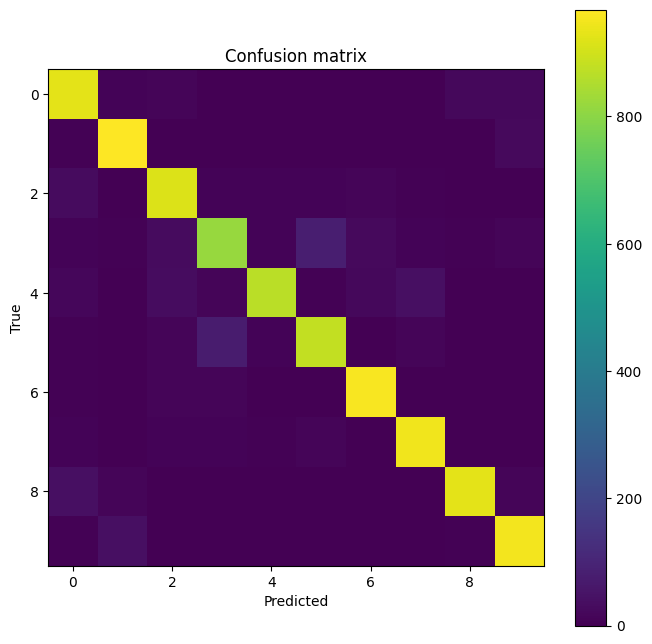

In [ ]:
try:
    if 'val_preds' in locals() and 'val_targets' in locals():
        cm = confusion_matrix(val_targets, val_preds)
        plt.figure(figsize=(8,8))
        plt.imshow(cm, interpolation='nearest')
        plt.title('Confusion matrix')
        plt.colorbar()
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
except Exception:
    pass